In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import splitfolders
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip /content/gdrive/MyDrive/DATA/DATA.zip

Archive:  /content/gdrive/MyDrive/DATA/DATA.zip
   creating: DATA/Apple/
  inflating: DATA/Apple/0.jpg        
  inflating: DATA/Apple/1.jpg        
  inflating: DATA/Apple/1_png.rf.a6b420f7a5b05bb52b72631201c7cc3f.jpg  
  inflating: DATA/Apple/10.jpg       
  inflating: DATA/Apple/1044.jpg     
  inflating: DATA/Apple/1045.jpg     
  inflating: DATA/Apple/1046.jpg     
  inflating: DATA/Apple/1047.jpg     
  inflating: DATA/Apple/1048.jpg     
  inflating: DATA/Apple/1049.jpg     
  inflating: DATA/Apple/1050.jpg     
  inflating: DATA/Apple/1051.jpg     
  inflating: DATA/Apple/1052.jpg     
  inflating: DATA/Apple/1053.jpg     
  inflating: DATA/Apple/1054.jpg     
  inflating: DATA/Apple/1055.jpg     
  inflating: DATA/Apple/1056.jpg     
  inflating: DATA/Apple/1057.jpg     
  inflating: DATA/Apple/1058.jpg     
  inflating: DATA/Apple/1059.jpg     
  inflating: DATA/Apple/1060.jpg     
  inflating: DATA/Apple/1061.jpg     
  inflating: DATA/Apple/1062.jpg     
  inflating: DATA/A

Splitting the Data

In [7]:
splitfolders.ratio('DATA', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 4812 files [00:00, 5066.36 files/s]


In [8]:
train_path='output/train'
test_path='output/test'
val_path='output/val'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(val_path,
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_datagen=ImageDataGenerator(rescale=1./255)

test_set=test_datagen.flow_from_directory(test_path,
                                         target_size=(150,150),
                                         batch_size=32,
                                          class_mode='categorical')

Found 3846 images belonging to 10 classes.
Found 478 images belonging to 10 classes.
Found 488 images belonging to 10 classes.


We have to compare the following:
0. VGG 16
1. Inception
2. Xception
3. Resnet50

# Transfer Learning

Defining functions for comparing models

In [9]:
def get_model_result(model_module1,model_module2,name):
    conv_base = model_module1(
        weights="imagenet",
        include_top=False,
        input_shape=(150, 150, 3))

    inputs=keras.Input(shape=(150,150,3))
    x = model_module2(inputs)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    name = keras.Model(inputs, outputs)

    optimizer=keras.optimizers.Adam(learning_rate=0.00001)
    
    name.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
    print(name.summary())
    history=name.fit(training_set,epochs=10,batch_size=32,validation_data=validation_set)
    
    return history

In [10]:
def get_plot(trained_model):
    fig, (axs1 , axs2) = plt.subplots(1, 2,figsize=(20,10))
    axs1.plot(trained_model.history['accuracy'], label='acc',color='red')
    axs1.plot(trained_model.history['val_accuracy'], label='val_acc',color='blue')
    axs1.set_title('Model Accuracy')
    axs1.set_ylabel('accuracy')
    axs1.set_xlabel('epoch')
    axs1.legend(['train', 'val'], loc='upper left')
    
    axs2.plot(trained_model.history['loss'], label='loss',color='red')
    axs2.plot(trained_model.history['val_loss'], label='val_loss', color='blue')
    axs2.set_title('Model Loss')
    axs2.set_ylabel('loss')
    axs2.set_xlabel('epoch')
    plt.show()

In [11]:
model_modules1=[
                keras.applications.VGG16,
                keras.applications.InceptionV3,
                keras.applications.Xception,
                keras.applications.ResNet50V2
                ]
model_modules2=[
                keras.applications.vgg16.preprocess_input,
                keras.applications.inception_v3.preprocess_input,
                keras.applications.xception.preprocess_input,
                keras.applications.resnet50.preprocess_input
                ]
names=['Vgg16','Inception','Xception','Resnet']

results=[]

for model_module1,model_module2,name in zip(model_modules1,model_modules2,names):
        print('='*50,'Model Training - {} '.format(name),'='*50,'\n')
        results.append(get_model_result(model_module1,model_module2,name))

================================================== Model Training - Vgg16  ================================================== 

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


121/121 [==============================] - 61s 369ms/step - loss: 2.6442 - accuracy: 0.1157 - val_loss: 2.2754 - val_accuracy: 0.1820
Epoch 2/10
121/121 [==============================] - 41s 342ms/step - loss: 2.2712 - accuracy: 0.1433 - val_loss: 2.2452 - val_accuracy: 0.2113
Epoch 3/10
121/121 [==============================] - 41s 341ms/step - loss: 2.1972 - accuracy: 0.1898 - val_loss: 2.1603 - val_accuracy: 0.2113
Epoch 4/10
121/121 [==============================] - 42s 346ms/step - loss: 2.1188 - accuracy: 0.2192 - val_loss: 1.9249 - val_accuracy: 0.2887
Epoch 5/10
121/121 [==============================] - 42s 347ms/step - loss: 2.0179 - accuracy: 0.2637 - val_loss: 1.9668 - val_accuracy: 0.2887
Epoch 6/10
121/121 [==============================] - 42s 345ms/step - loss: 1.9251 - accuracy: 0.3032 - val_loss: 1.8031 - val_accuracy: 0.3494
Epoch 7/10
121/121 [==============================] - 42s 346ms/step - loss: 1.8680 - accuracy: 0.3229 - val_loss: 1.6435 - val_accuracy: 0.4

 Visualization of Models

## VGG 16


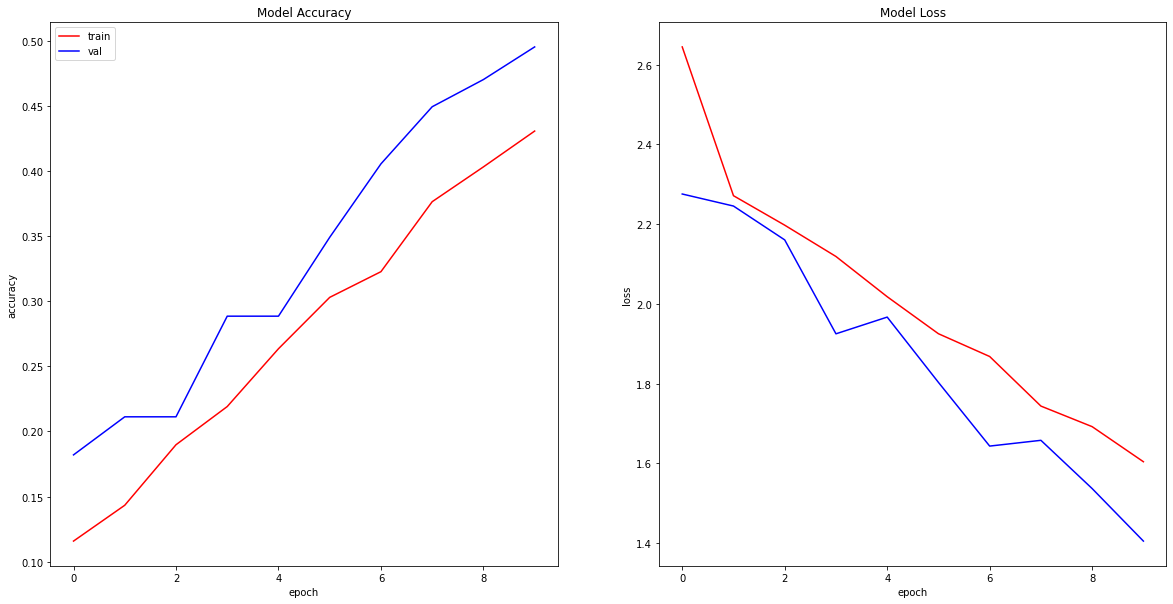

In [12]:
get_plot(results[0])

## Inception

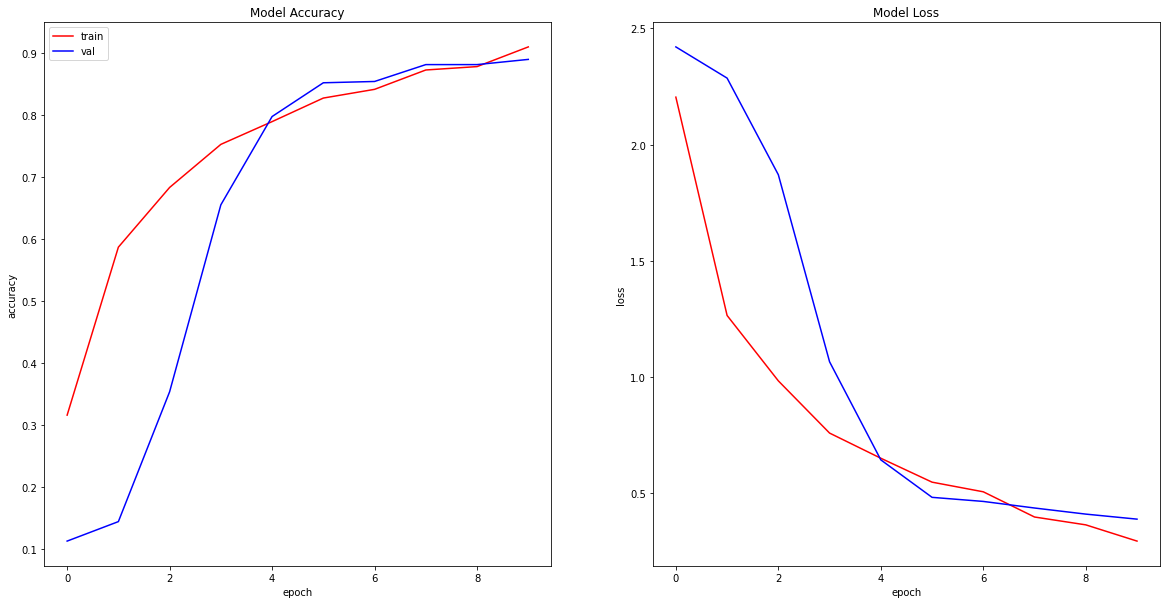

In [13]:
get_plot(results[1])

Exception

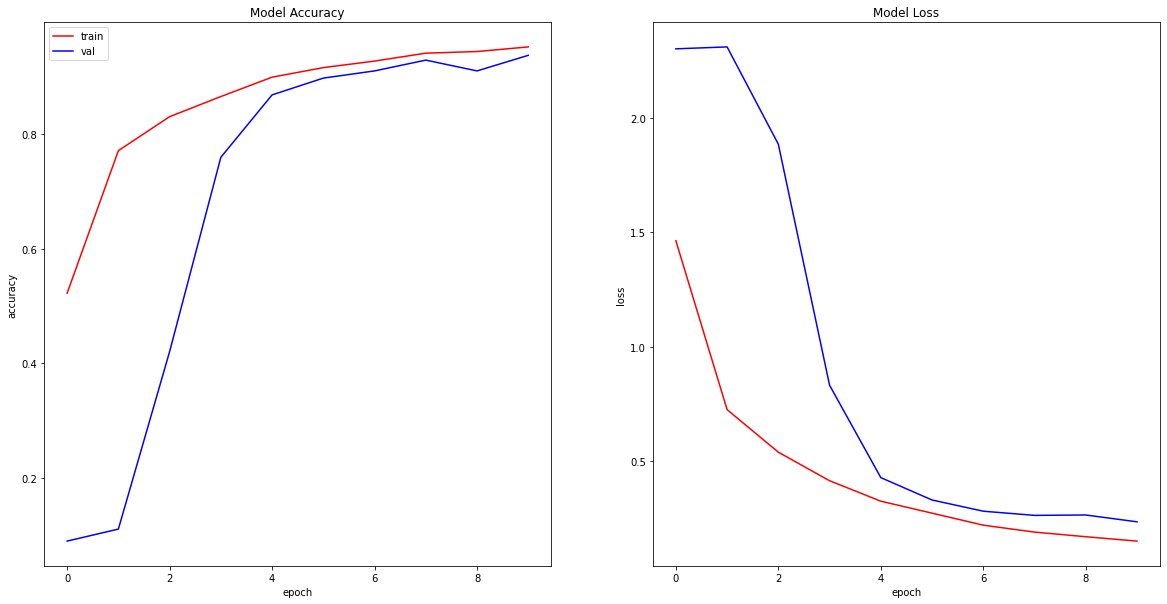

In [14]:
get_plot(results[2])

Resnet

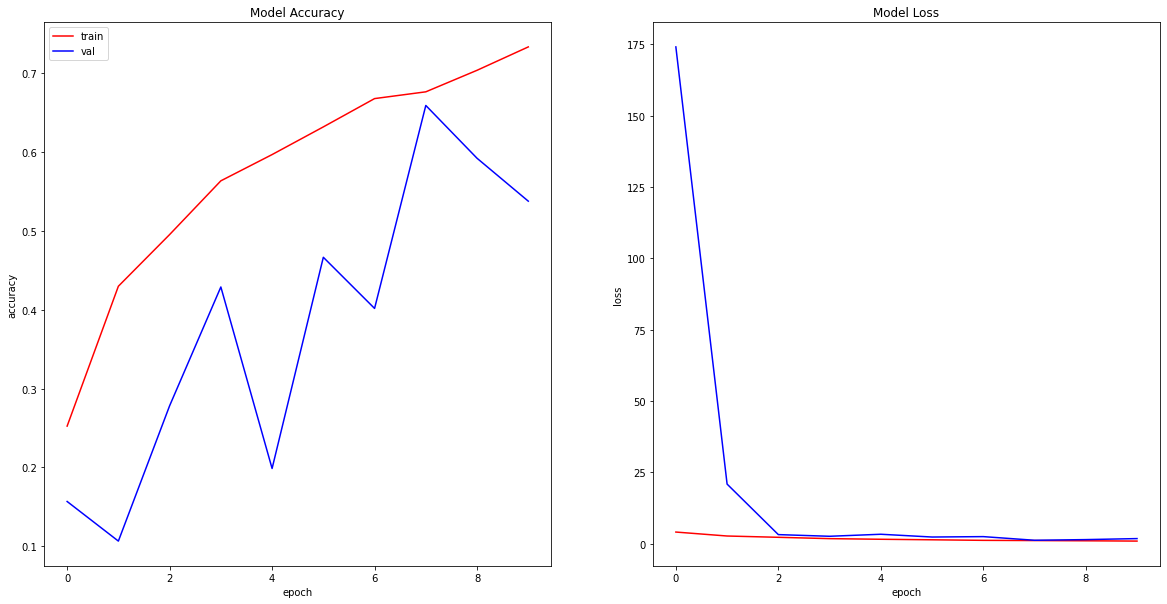

In [15]:
get_plot(results[3])

Comparison

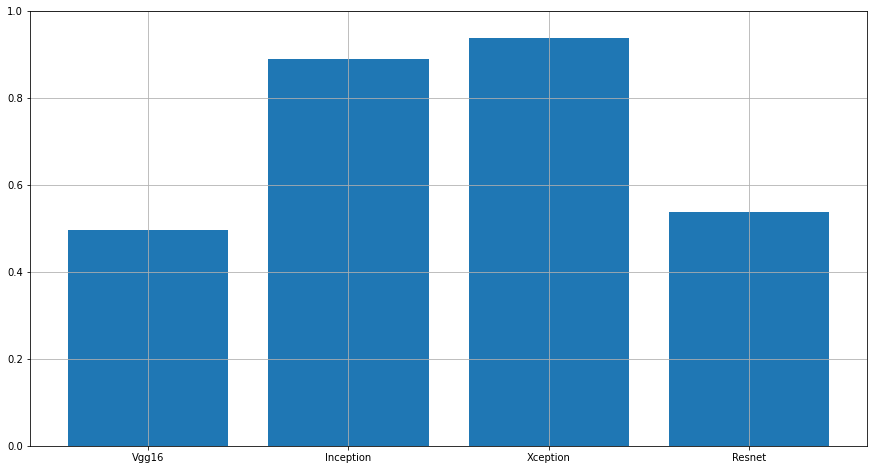

In [16]:
scores=[
        results[0].history['val_accuracy'][-1],
        results[1].history['val_accuracy'][-1],
        results[2].history['val_accuracy'][-1],
        results[3].history['val_accuracy'][-1]
        ]       

plt.figure(figsize=(15,8))
plt.bar(names,scores)
plt.ylim(0,1)
plt.grid()
plt.show()

In [17]:
for name,score in zip(names,scores):
    print('Model {} Accuracy -> {}'.format(name,score))

Model Vgg16 Accuracy -> 0.4958159029483795
Model Inception Accuracy -> 0.8891213536262512
Model Xception Accuracy -> 0.9372385144233704
Model Resnet Accuracy -> 0.5376569032669067
